# Introduction

It is no secret that many students from ages 15-22 enjoying drinking alcohol (often underage), but is this a cause for concern academically? Using a dataset that contains information about students' (ages 15-22) alcohol consumption, social lives, and academic success, this tutorial will attempt to find the largest factors in determining student alcohol consumption, and if their alcohol consumption impacts a students' academic success. If determined that alcohol consumption does affect students' academics negatively, what outside factors cause this alcohol consumption?

In determining this, this tutorial will cover a wide range of data science topics will be covered, including importing and cleaning a dataset, analyzing and interpreting the data via exploratory data analysis using several Python libraries, hypothesis testing and machine learning.

# Getting Started

Before we start, we must make the appropriate imports of the Python libraries we will use. To store the data in DataFrames (tables), we will use Pandas. For exploratory data analysis, we will use Seaborn and matplotlib. Lastly, for additional Python computing and analysis, we will use SciPy and NumPy. 

To install these libraries, make sure you have Anaconda or pip installed (links). Then, run the command:

```conda install <package>``` 

or 

```pip install <package>``` 

depending on which package management system you have set up.

For more information or documentation for any of these libraries, look at the last section for further resources. **(INSERT LINKS FOR MORE INFORMATION AT BOTTOM)**

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
sns.set_context({"figure.figsize": (24, 10)})

## Data Collection

In order to analyze the data on student alcohol consumption, we must first load in the datasets available on Kaggle (INSERT LINK HERE). The two datasets consist of surveys from math and Portuguese courses in two secondary schools and are separated into two separate files.

Using Pandas, I load each survey's csv file into their respective DataFrame.

In [39]:
stud_math = pd.read_csv('student_alc.csv')
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [40]:
stud_port = pd.read_csv('student_port.csv')
stud_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## Entity Resolution

Next, another important part in the data collection and cleaning process is Entity Resolution. According to UCI Machine Learning, who posted the dataset on Kaggle, there are nearly 400 students that are in both the math and Portuguese class, and thus show up in both surveys. Although tempting to just append the datasets together, this will skew the data since some students will show up twice.

To resolve this, we must use the information in the survey to match students who are in both classes. First, we add a StudentID column to the math class' DataFrame to serve as a primary key (and eventually foreign key for the Portuguese class'), by assigning each student a unique number.

In [41]:
numrows = stud_math.shape[0]
ids = range(1, numrows+1)
stud_math['StudentID'] = pd.Series(ids)
stud_math.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,StudentID
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,5


Next, we must use the Portuguese class DataFrame to match StudentID's from the math class. Using only information that would not have fluctuated for a student based on the course (such as school, gender, address, guardian information), we can query the math class to identify the same students in the Portuguese dataset. If/when a match is found, we assign the row the same StudentID. If a match is not found, a new and unique StudentID is assigned to the row.

In [42]:
newID = 396
stud_port['StudentID'] = np.nan
stud_port.head()
for i, row in stud_port.iterrows():
    mathRow = stud_math[(stud_math.school == row.school) & (stud_math.sex == row.sex) & \
                        (stud_math.age == row.age) & (stud_math.address == row.address) &\
                        (stud_math.famsize == row.famsize) & (stud_math.Pstatus == row.Pstatus) &\
                        (stud_math.Medu == row.Medu) & (stud_math.Fedu == row.Fedu) &\
                        (stud_math.Mjob == row.Mjob) & (stud_math.Fjob == row.Fjob) &\
                        (stud_math.reason == row.reason) & (stud_math.nursery == row.nursery) &\
                        (stud_math.internet == row.internet) & (stud_math.higher == row.higher) &\
                        (stud_math.romantic == row.romantic) & (stud_math.activities == row.activities) &\
                        (stud_math.guardian == row.guardian) & (stud_math.traveltime == row.traveltime)]
    if len(mathRow) == 1:
        stud_port.set_value(i, 'StudentID', mathRow.iloc[0]['StudentID'])
    else:
        stud_port.set_value(i, 'StudentID', newID)
        newID += 1
stud_port.StudentID = stud_port.StudentID.astype(int)
stud_port.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,StudentID
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,4,0,11,11,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,2,9,11,11,2
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,6,12,13,12,3
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,0,14,14,14,4
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,0,11,13,13,5


After identifying the same students in both courses, we can drop the columns we do not need in both DataFrames.

In [43]:
#deleted rows that are not needed

del stud_math['reason']
del stud_math['guardian']
del stud_math['schoolsup']
del stud_math['famsup']
del stud_math['nursery']

del stud_port['reason']
del stud_port['guardian']
del stud_port['schoolsup']
del stud_port['famsup']
del stud_port['nursery']

## Exploratory Data Analysis

Now that we have all of our datasets imported into DataFrames, we can start to analyze the data to find any trends. One of the easiest and most visual ways to view the data is through exploratory data analysis, where we can plot the data using Seaborn and matplotlib to see if we can observe any obvious trends.

Based on the survey, there are several different factors of a student's life that we can explore to see if alcohol consumption is affected most by:

- Demographic information (How does a student's gender affect their alcohol consumption habits?)

- Home life (How do family relationships affect student alcohol consumption habits?)

- Academic performance (Is it true that students who drink more perform worse in class?)

### Student Demographics

Since our main goal is to find the potential main factors causing or correlated with student alcohol consumption, we should first observe student alcohol habits as a whole. We can do this by creating a histogram using the 'Walc' column in the DataFrame, which is an ordinal scale from 1-5, with 5 indicating very high weekend alcohol consumption.

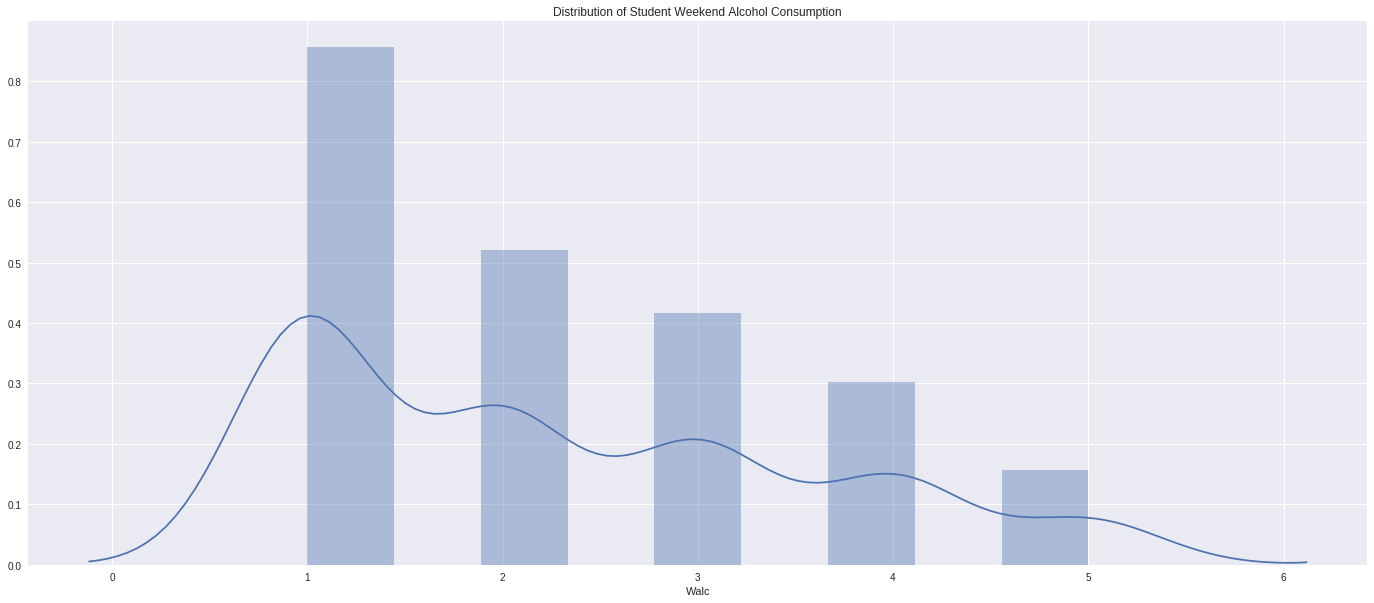

In [44]:
sns.distplot(stud_port['Walc'])
plt.title('Distribution of Student Weekend Alcohol Consumption')
plt.show()

We can clearly see that although it seems the plurality of students have "very low" weekend alcohol consumption, many (if not most) students have indicated they consume alcohol on the weekends. Nevertheless, we observe a right-skew here, meaning that these scores fall towards the lower side of the scale.

One of the simplest ways to separate the data is by sex. Do males tend to have higher alcohol consumption habits than females? To see if there is a trend here, we can create a grouped bar chart, where each score is separated by the number of students who selected that score by sex.

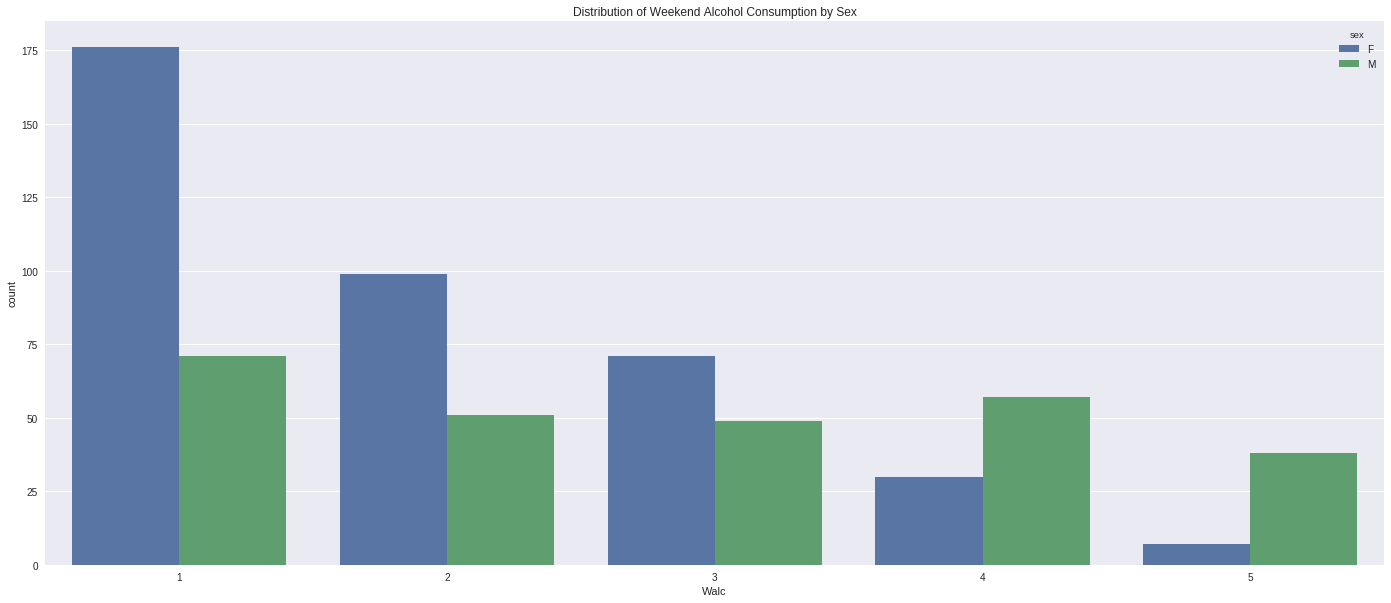

In [45]:
sns.countplot(x="Walc", hue="sex", data=stud_port)
plt.title('Distribution of Weekend Alcohol Consumption by Sex')
plt.show()

In this bar chart, we can clearly see that a higher proportion of males have indicated higher weekend drinking habits than females. While the female distribution is very skewed to the right, the distribution for males seems to be more bimodal, with peaks at Walc=1 and Walc=4. This means that that there are a high proportion of males in this survey that do have moderate to high drinking habits on the weekends.

Another factor that may predict student alcohol consumption habits is their age. We can create a bar chart that displays the average Walc score for each age of students represented in the survey.

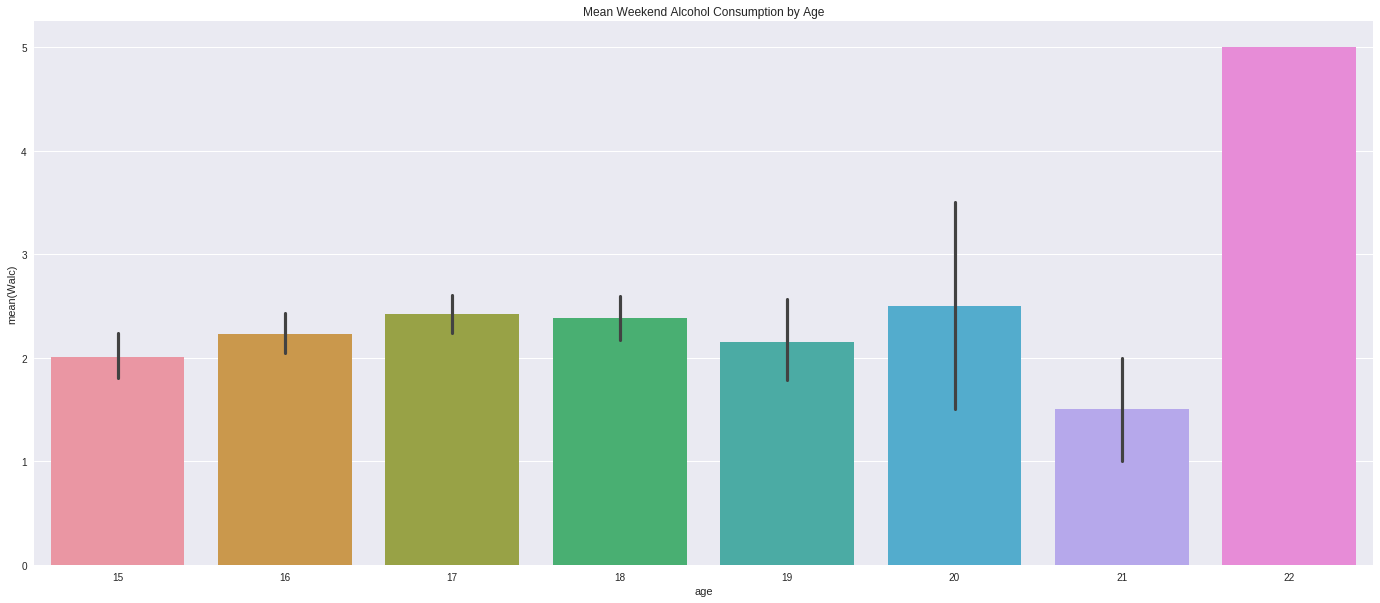

In [46]:
sns.barplot(x="age", y="Walc", data=stud_port)
plt.title('Mean Weekend Alcohol Consumption by Age')
plt.show()

While there seems to be no definitive trend of consumption by age, the one thing that does jump out is the average Walc score of 5 for students 22 years old. However, this is slightly misleading, as there is most likely only one or two students who are 22, which skews the average. Disregarding the spike at 22 years old, however, the rest of the distribution looks to be fairly consistent, with slight bimodal peaks at 20 and 17.

### Student Home Life

Next, we may be tempted to see how a student's home and family life affects their alcohol habits.

Again, using Seaborn, we can create a barplot seeing how a student's relationship with his/her family affects alcohol consumption habits. We may expect that a student with a worse family relationship has high alcohol consumption habits, whereas students with stronger family relationships have lower alcohol consumption habits.

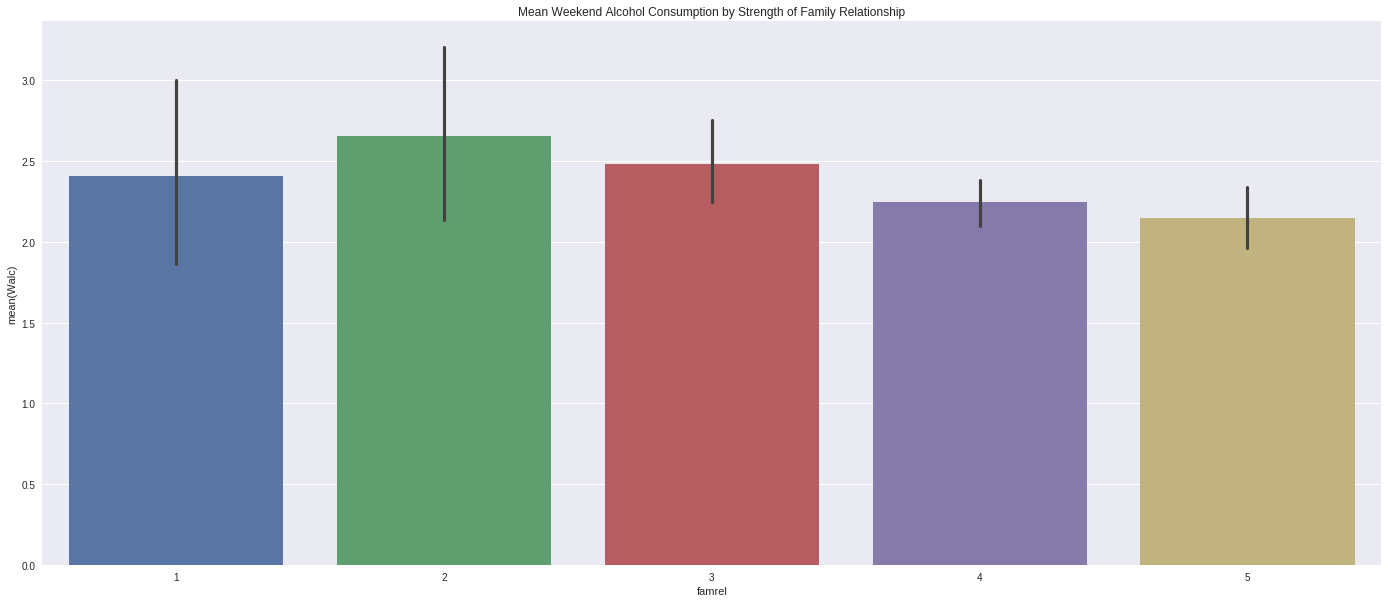

In [47]:
sns.barplot(x="famrel", y="Walc", data=stud_port)
plt.title('Mean Weekend Alcohol Consumption by Strength of Family Relationship')
plt.show()

Although there is not the highest average alcohol consumption habits with the worst family relationship option, we do see a peak at famrel = 2. From there, we see a decreasing trend of student alcohol consumption habits. This unimodal, right-skewed distribution confirms our inhibition that there does seem to be a negative correlation between student alcohol habits and strength of family relationships.

Going along the same thought process, we can next plot a bar chart of student alcohol habits by whether or not a student's parents live together or apart.

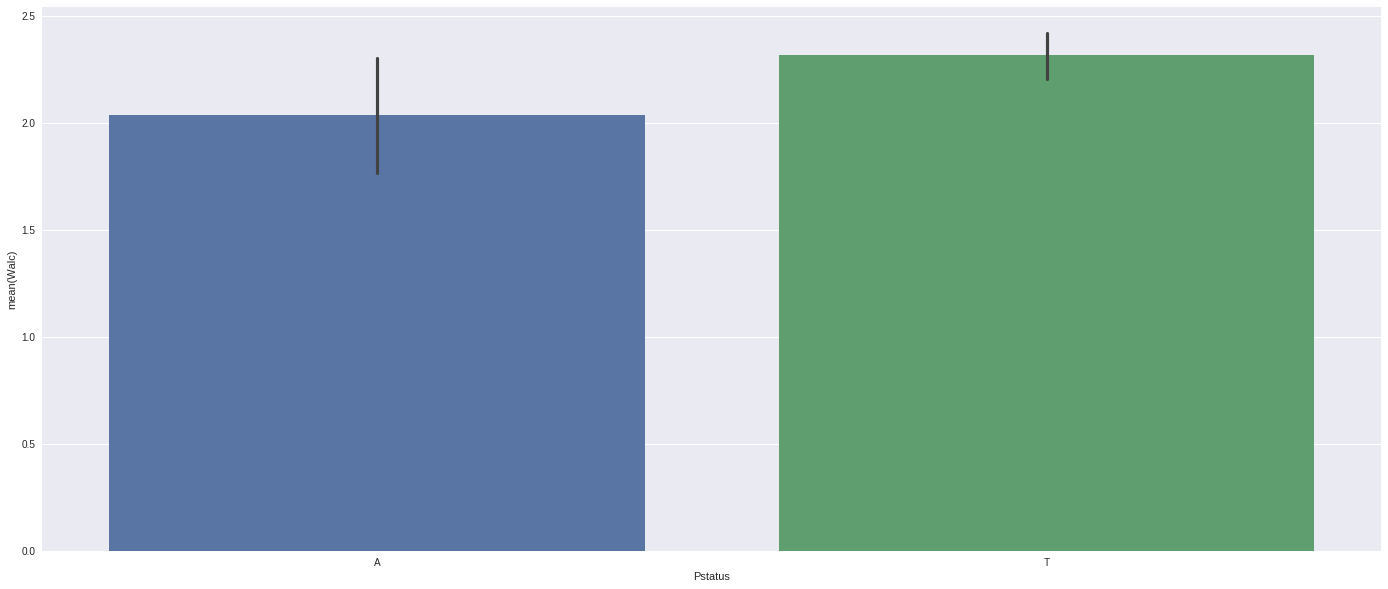

In [48]:
sns.barplot(x="Pstatus", y="Walc", data=stud_port)
plt.show()

Based on the bar plot above, we see that students with parents that live together (T) tend to have slightly higher alcohol consumption habits on the weekend than that of students with parents that live apart (A).

### Student Academic Performance

Do students who perform worse in school tend to have higher alcohol consumption? Unlike the other two factors we observed above (demographic and home life), academic performance is something that can actually be controlled. As a result, it would seem that we are more likely to observe trends here, as alcohol performance may serve as a predictor for how students perform in school.

To observe a distribution of academic performance by student alcohol consumption habits, we can create a violin plot. The below chart shows the distribution of final (G3) grades in the Portuguese class for each 'Walc' score (alcohol consumption habits on the weekend).

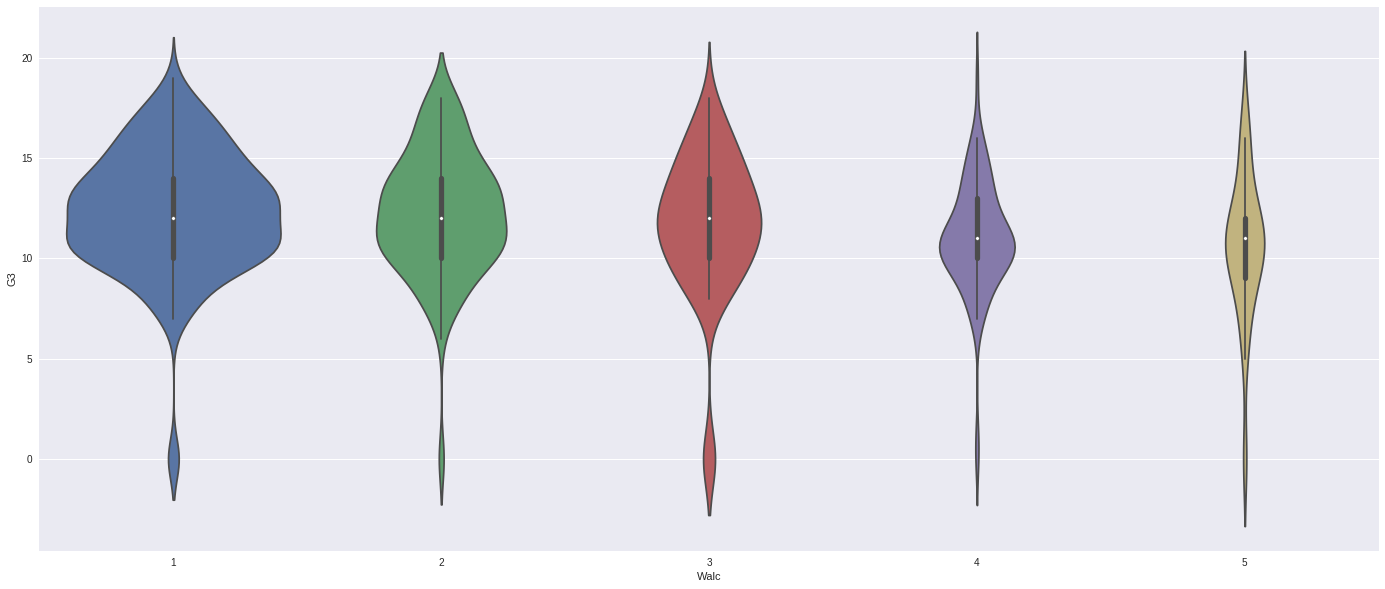

In [53]:
sns.violinplot(x='Walc', y='G3', data=stud_port, scale='count')
plt.show()

Perhaps unsurprisingle, we can note a downwards trend in grades for higher alcohol consumption habits. For low alcohol consumption rates, with Walc=1 or Walc=2, the grade distributions tend to skew towards higher grades (where 20 is the max grade score).

In [50]:
def getScatterPlotByColumn(colname):
    fig, ax = plt.subplots()
    ax.scatter(stud_alc[colname], stud_alc['Dalc'])
    # generate scatterplot between population (x) and dropouts (y)
    m, y = np.polyfit(stud_alc[colname], stud_alc['Dalc'], 1)
    plt.plot(stud_alc[colname], m * stud_alc[colname] + y, '-',color="magenta")
    plt.title('Dalc vs {} '.format(colname))
    plt.xlabel(colname)
    plt.ylabel('Dalc')
    plt.show()
    slope, intercept, r_value, p_value, std_err = stats.linregress(stud_alc[colname], stud_alc['Dalc'])
    print('r^2 value for correlation between {} and Dalc: {}'.format(colname, r_value**2))

NameError: name 'stud_alc' is not defined

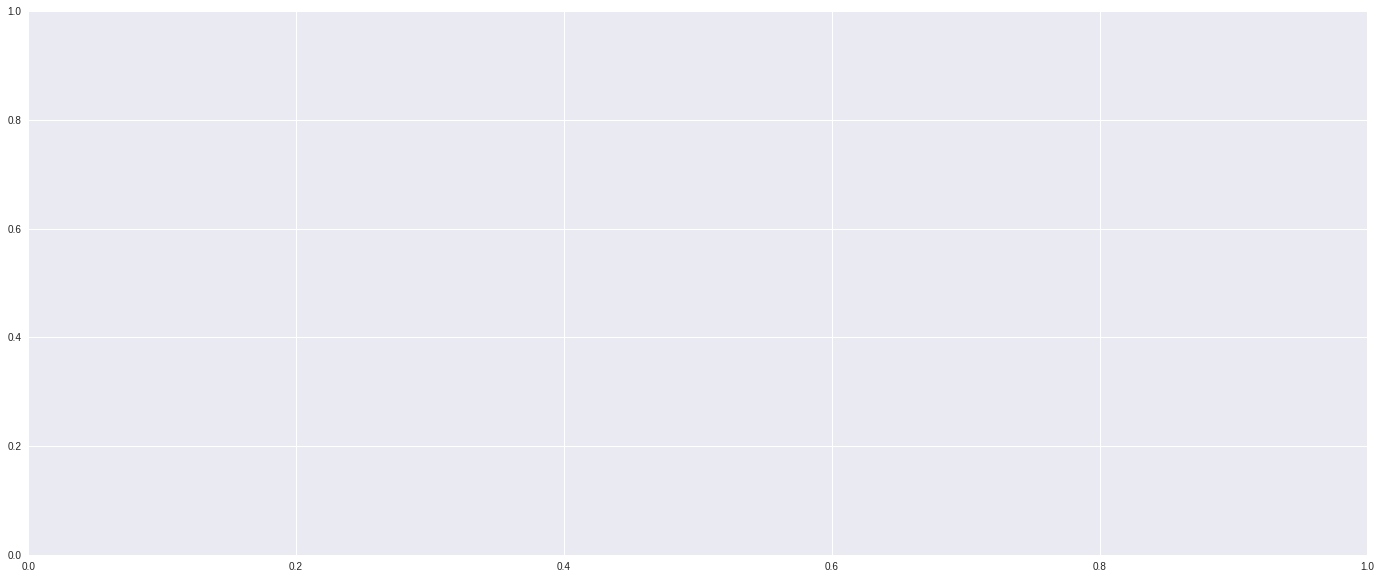

In [51]:
getScatterPlotByColumn('age')

In [ ]:
Fam_size = plt.figure(figsize=(20,15))
fam = Fam_size.add_subplot(3, 5,1)

fam.set_title('Family Size')

# Retrieve values from dataframe in 'workclass' and add them to the figure
stud_alc['famsize'].value_counts().plot(color = "green", kind="bar", axes=fam)
plt.show()

In [ ]:
Fam_size = plt.figure(figsize=(20,15))
fam = Fam_size.add_subplot(3, 5,1)

fam.set_title('Student Age')

# Retrieve values from dataframe in 'workclass' and add them to the figure
stud_alc['age'].value_counts().plot(color = "green", kind="bar", axes=fam)
plt.show()

In [ ]:
#box whsiker for sex vs dalc and grades for math class
g = sns.FacetGrid(stud_alc, col='Dalc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'sex', 'G1')
sns.plt.show()

In [ ]:
#box whsiker for sex vs dalc and grades for portugese class
g = sns.FacetGrid(stud_port, col='Dalc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'sex', 'G1')
sns.plt.show()

In [ ]:
#box whsiker for sex vs dalc and grades
g = sns.FacetGrid(stud_alc, col='Dalc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'sex', 'G2')
sns.plt.show()

In [ ]:
#box whsiker for sex vs walc and grades
g = sns.FacetGrid(stud_alc, col='Walc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'Pstatus', 'G3')
sns.plt.show()

In [ ]:
#box whsiker for sex vs walc and grades for portugese class
g = sns.FacetGrid(stud_port, col='Walc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'sex', 'G1')
sns.plt.show()

In [ ]:
def getScatterPlotByColumn2(colname):
    fig, ax = plt.subplots()
    ax.scatter(data[colname], data['G3'])
    # generate scatterplot between population (x) and dropouts (y)
    m, y = np.polyfit(data[colname], data['G3'], 1)
    plt.plot(data[colname], m * data[colname] + y, '-',color="magenta")
    plt.title('G3 vs {} '.format(colname))
    plt.xlabel(colname)
    plt.ylabel('G3')
    plt.show()
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[colname], data['G3'])
    print('r^2 value for correlation between {} and G3: {}'.format(colname, r_value**2))

In [ ]:
getScatterPlotByColumn2('goout')

In [ ]:
#study time vs grades
getScatterPlotByColumn2('studytime')

In [ ]:
sns.violinplot(x= 'sex', y='G3', hue='Walc', data=stud_alc, scale='count',size = 20)
sns.plt.show()

In [ ]:
#box whsiker for sex vs walc and grades for portugese class
sns.violinplot(x= 'sex', y='G3', hue='Walc', data=stud_port, scale='count',size = 20)
sns.plt.show()

In [ ]:
sns.violinplot(x= 'sex', y='G3', hue='Dalc', data=stud_alc, scale='count',size = 20)
sns.plt.show()

In [ ]:
g = sns.FacetGrid(stud_alc, col='Walc', size=4, aspect=.5)
g = g.map(sns.boxplot, 'goout', 'G3')
sns.plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plt.title('Correlation Heat Map')
sns.heatmap(data.corr(),annot = True,fmt = ".2f",cbar = True)
plt.xticks(rotation=90)
plt.yticks(rotation = 0)
plt.show()
##I Found this is one of the kernels 